# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment.

In [1]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from IPython.display import display

seed = 2023
np.random.seed(seed)

## Question 1: /20 pts


Customer Lifetime Value (CLV) is the total income a business can expect from a customer over the entire period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth. We want to predict CLV for an auto insurance company.

1. Read in the `Vehicle_Insurance.csv` dataset and display the last 5 rows.
2. Conduct the required data preparation.

### 1.1 Read the dataset and display the last 5 rows

In [2]:
df = pd.read_csv('Vehicle_Insurance.csv')
df.tail()

,clv,Coverage,Gender,Income,Marital.Status,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Renew.Offer.Type,Total.Claim.Amount,Vehicle.Class
8625,4100.398533,Premium,F,47761,Single,104,0,1,Offer1,541.282007,Four-Door Car
8626,3096.511217,Extended,F,21604,Divorced,79,0,1,Offer1,379.200000,Four-Door Car
8627,8163.890428,Extended,M,0,Single,85,3,2,Offer1,790.784983,Four-Door Car
8628,7524.442436,Extended,M,21941,Married,96,0,3,Offer3,691.200000,Four-Door Car
8629,2611.836866,Extended,M,0,Single,77,0,1,Offer4,369.600000,Two-Door Car


### 1.2 Remove the rows with "clv" $> 16000$ as well as those with "clv" $< 2200$ from the dataset. What's the shape of the dataframe now?

In [3]:
# Removing rows with clv < 2200 and clv > 16000
df = df[(df['clv'] <= 16000) & (df['clv'] >= 2200)]

df.shape

(8212, 11)

### 1.3 Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 3 rows.

In [4]:
cat_columns = [
    'Coverage',
    'Gender',
    'Marital.Status',
    'Renew.Offer.Type',
    'Vehicle.Class',
]

# Applying OneHotEncoder to the cat_columns listed
ct = ColumnTransformer([('onehot', OneHotEncoder(drop='first'), cat_columns)], remainder='passthrough')
df_encoded = pd.DataFrame(ct.fit_transform(df), columns=ct.get_feature_names_out())

# Displaying the first 3 rows of the encoded dataframe
df_encoded.head(3)

,onehot__Coverage_Extended,onehot__Coverage_Premium,onehot__Gender_M,onehot__Marital.Status_Married,onehot__Marital.Status_Single,onehot__Renew.Offer.Type_Offer2,onehot__Renew.Offer.Type_Offer3,onehot__Renew.Offer.Type_Offer4,onehot__Vehicle.Class_Luxury Car,onehot__Vehicle.Class_Luxury SUV,onehot__Vehicle.Class_SUV,onehot__Vehicle.Class_Sports Car,onehot__Vehicle.Class_Two-Door Car,remainder__clv,remainder__Income,remainder__Monthly.Premium.Auto,remainder__Number.of.Open.Complaints,remainder__Number.of.Policies,remainder__Total.Claim.Amount
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2763.519279,56274.0,69.0,0.0,1.0,384.811147
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6979.535903,0.0,94.0,0.0,8.0,1131.464935
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12887.431650,48767.0,108.0,0.0,2.0,566.472247


### 1.4 Use `pandas.DataFrame.apply` to apply square root transformation to "Total.Claim.Amount" and log to the target variable. And then, create your `X` and `y`. (No training/test splitting yet) 

In [5]:
# Applying square root transformation to Total.Claim.Amount
df_encoded.apply(lambda x: np.sqrt(x) if x.name == 'remainder__Total.Claim.Amount' else x)

# Applying log to the target variable
df_encoded.apply(lambda x: np.log(x) if x.name == 'remainder__clv' else x)

# Create X and y
X = df_encoded.drop('remainder__clv', axis=1)
y = df_encoded['remainder__clv']

### 1.5 Build a new design matrix by applying polynomial expansion on the `X` from Question 1.4.

Hint: Specify degree=2 and do NOT include the column with power 0 (i.e., the column with all elements being 1)

In [6]:
# New design matrix by applying polynomial expansion on X, specify degree = 2 and not including column with power 0 (all elements 1)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

### 1.6 Standardize your design matrix (from Question 1.5) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [7]:
# Standardizing design matrix with StandardScaler and storing as dataframe
scaler = StandardScaler()
X_poly_scaled = pd.DataFrame(scaler.fit_transform(X_poly), columns=poly.get_feature_names_out())

### 1.7 What is the shape of the resultant DataFrame obtained from question 1.6?

In [8]:
# Shape of X_poly_scaled
X_poly_scaled.shape

(8212, 189)

## Question 2: /7 pts

Split the data into training and test sets. Hold out 30% of observations as the test set.  Pass `random_state=seed` to `train_test_split` to ensure you get the same sets per run. The design matrix to pass in to the splitter function is the dataframe whcih you got in Question 1.6. As for the target, you have created it in Question 1.4.

In [9]:
# Splitting into training and test sets, 30% for test
X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, test_size=0.3, random_state=seed)

# Number of observations in training data set
print(X_train.shape[0])

# Average target variable value in training data set (2 decimal places)
print(round(y_train.mean(), 2))


5748
6261.15


How many observations in your traning data set? What is the average value of the target variable in the traning data set (keep 2 decimal place)?

**YOUR ANSWER HERE:** [2pts]

There are 5748 observations in the training set.

The average value of the target variable is 6261.15

## Question 3: /23 pts

### 3.1 Create a SciKit Learn `Ridge` regression object. Using this object, run a ridge regression analysis of the target variable against all the transformed predictor variables using your training data. Include the arguement `alpha=4.0`. In addition, the ridge regression should be fitted with the intercept.

In [10]:
# Ridge regression analysis with ScitKit Learn, alpha = 4.0, and fitting with the intercept
ridge = skl.Ridge(alpha=4.0, fit_intercept=True)
ridge.fit(X_train, y_train)

Ridge(alpha=4.0)

### 3.2 Vary the ridge coeficient `alpha` according to the hint. Use `cross_val_score()` to select the best `alpha` based on 'mean_squared_error'. Include the argument `cv=5`. Report the `alpha` that yields the smallest mean_squared_error.   

In [11]:
# hint: lam = np.exp(np.linspace(-4,1,10))

# Varying ridge coefficient alpha according to the hint, use cross_val_score() to select best alpha based on mean squared error, cv=5
lam = np.exp(np.linspace(-4,1,10))
mse = []
for l in lam:
    ridge = skl.Ridge(alpha=l, fit_intercept=True)
    mse.append(-cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())

# Best alpha value
best_alpha = lam[np.argmin(mse)]
print(best_alpha)

2.718281828459045


### 3.3 Re-fit the ridge regression with `alpha` being the value obtained in the previous question. `Print` the first 3 parameters of your model.

In [12]:
# Re-fitting ridge regression with best_alpha, and printing first 3 parameters of the model
ridge = skl.Ridge(alpha=best_alpha, fit_intercept=True)
ridge.fit(X_train, y_train)
ridge.coef_[:3]

array([ 39.60969991, -97.45530286, 367.97413322])

### 3.4 Fit the linear regression without any penalty, and the regression should be fitted with the intercept. `Print` the first 3 parameters of your model.

In [13]:
# Fitting linear regression without any penalty with the intercept, then printing first 3 parameters of the model
lin = skl.LinearRegression(fit_intercept=True)
lin.fit(X_train, y_train)
lin.coef_[:3]

array([ 1.32890424e+15, -2.13799074e+15, -1.39914138e+15])

Comparing the parameters that you obtain in questions 3.3 and 3.4, what do you find?

**YOUR ANSWER HERE:** [2pts]

The parameters are much smaller in the ridge regression model than they are the linear regression model. This is on the scale of many magnitudes of 10.

### 3.5 Use your trained model from Question 3.4 to predict over the test set and `print` the first 5 prediction values.

In [14]:
# Predicting over the test set with the ridge model, then printing the first 5 predictions
y_pred_ridge = ridge.predict(X_test)
y_pred_ridge[:5]

array([9614.53377222, 4512.85389836, 7430.45954417, 3515.71637196,
       5499.51570595])

## Question 4: /25 pts

### 4.1 Consider to fit a Lasso regression to the train dataset. Use `lasso_path()` to show the full path of the first 20 coefficients of the Lasso regression. Include the arguement `eps=8e-3` and `n_alphas=50`.

Text(0.5, 1.0, 'Lasso Path')

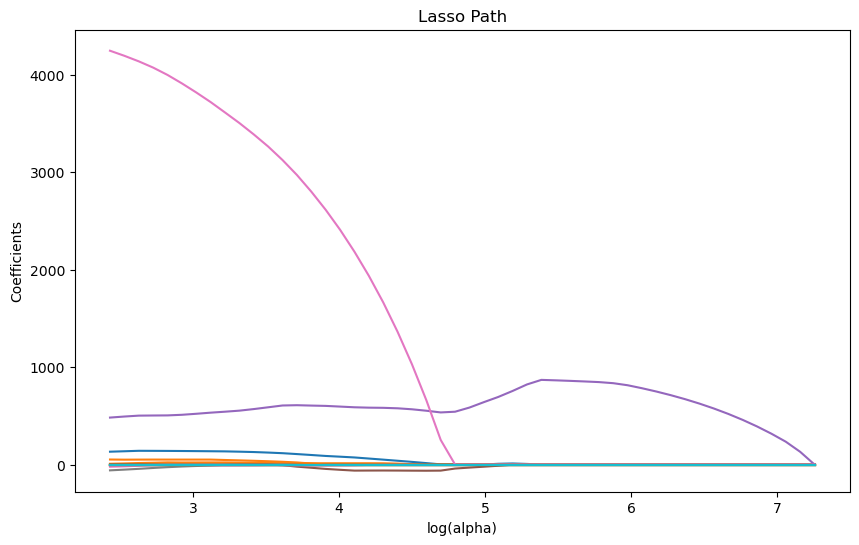

In [15]:
# Draw a plot to show the path. Legend is not required in the plot.

# Creating Lasso regression to the train dataset, and then use lasso_path to show full path of first 20 coefficients, eps=8e-3 and n_alphas=50
alphas_lasso, coefs_lasso, _ = skl.lasso_path(X_train, y_train, eps=8e-3, n_alphas=50)

# Plotting the path of first 20 coefficients
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(np.log(alphas_lasso), coefs_lasso[i], label=X_train.columns[i])
plt.xlabel('log(alpha)')
plt.ylabel('Coefficients')
plt.title('Lasso Path')

Describe the trend that shows in your figure.

**YOUR ANSWER HERE:** [3pts] 

All of the coefficients approach 0 rapidly from their starting point. In general, the further a coefficient is from 0 at the start, the longer it takes to converge to 0.

### 4.2 Use the Scikit Learn's cross-validated LASSO to automatically search for the best tuning parameter of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameter and the number of the non-zero coefficients in the model.

In [16]:
# use cross-validated LASSO to find best tuning parameter of lasso regression on training set with intercept, eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed
lasso_cv = LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, fit_intercept=True)
lasso_cv.fit(X_train, y_train)

# Best tuning parameter and number of non-zero coefficients
best_alpha_lasso = lasso_cv.alpha_
non_zero = np.sum(lasso_cv.coef_ != 0)
print('Best Tuning Parameter: ' + str(best_alpha_lasso))
print('Number of Non-Zero Coefficients: ' + str(non_zero))

Best Tuning Parameter: 11.473715376927393
Number of Non-Zero Coefficients: 100


### 4.3 Use the Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the Elasticnet regression with intercept on the training data set. Include the same argument as question 4.2 as well as `l1_ratio=[.7, .9, .95, .99,1]`. Report the best tuning parameters.

In [17]:
# Using ElasticNet to search for best tuning parameters of Elasticnet regression with intercept on training set. Same arguments as 4.3 and l1_ratio = [.7, .9, .95, .99, 1]
elastic = sk.linear_model.ElasticNetCV(l1_ratio=[.7, .9, .95, .99, 1], eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed, fit_intercept=True)
elastic.fit(X_train, y_train)

# Best tuning parameters
best_alpha_elastic = elastic.alpha_
best_l1_ratio = elastic.l1_ratio_
print('Best Tuning Parameter: ' + str(best_alpha_elastic))
print('Best l1_ratio: ' + str(best_l1_ratio))

Best Tuning Parameter: 11.473715376927393
Best l1_ratio: 1.0


From the obtained tuning parameters, is the Elasticnet regression model equivalent to the Lasso regression? Briefly describe the reason. 

**YOUR ANSWER HERE:** [3pts]

Yes, the models are equivalent as the tuning parameters are equivalent.

## Question 5: /16 pts

### 5.1 Start from the regression model in question 3.4, use `SequentialFeatureSelector()` to conduct the forward selection for the features of the regression model. Include the argument `n_features_to_select=20`. Report the indices of the selected features. 

FYI: Running this using 8 physical cores took about 1 minute for me.

In [18]:
# Forward selection for the features of the regression model (lin) with SequentialFeatureSelector
sfs = SequentialFeatureSelector(lin, direction='forward', n_features_to_select=20)
sfs.fit(X_train, y_train)

# Indices of the selected features
selected_features = sfs.get_support(indices=True)
selected_features

array([ 14,  16,  17,  33,  42,  47,  56,  61,  73,  96, 106, 108, 109,
       116, 178, 179, 181, 182, 185, 186], dtype=int64)

What do you need to change about the argument in your model if you want to conduct a backward selection?

**YOUR ANSWER HERE:** [2pts] 

direction = 'backward'

### 5.2 Re-fit the regular linear regression based on the traning set by using the selected features from the question 5.1. Report the first 3 parameters of your model as indicated with the print function.

In [19]:
# Re fitting linear regression using the selected features, then printing the first 3 parameters of the model
lin.fit(X_train.iloc[:, selected_features], y_train)
lin.coef_[:3]

array([1760.61693031, 4480.38961851, -270.31267526])

## Question 6: /9 pts

### 6.1 Make predictions on the test set using your models in questions 3.3, 4.2, 4.3, and 5.2, respectively. Together with the predicted values obtained in question 3.5, report the first 5 rows of predicted values obtained from different models in a single DataFrame.

In [20]:
# Making predictions on the test set with: ridge, lasso_cv, elastic, and sfs. Reporting first 5 rows of predicted values in a single dataframe for all models
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)
y_pred_elastic = elastic.predict(X_test)
y_pred_sfs = lin.predict(X_test.iloc[:, selected_features])

# Creating a dataframe with all predictions
df_pred = pd.DataFrame({'ridge': y_pred_ridge, 'lasso_cv': y_pred_lasso, 'elastic': y_pred_elastic, 'sfs': y_pred_sfs})

# Displaying the first 5 rows
df_pred.head()

,ridge,lasso_cv,elastic,sfs
0,9614.533772,9057.998667,9057.998667,8927.480462
1,4512.853898,4574.748276,4574.748276,4474.121456
2,7430.459544,7410.172328,7410.172328,7700.687824
3,3515.716372,3535.343998,3535.343998,3902.464425
4,5499.515706,5356.574276,5356.574276,5602.127185


### 6.2 Use `mean_squared_error()` to assess the performance of different models based on all the predicted values mentioned in Question 6.1.  

In [21]:
# Assessing performance of different models with mean_squared_errors based on predicted values
mse_ridge = metrics.mean_squared_error(y_test, y_pred_ridge)
mse_lasso = metrics.mean_squared_error(y_test, y_pred_lasso)
mse_elastic = metrics.mean_squared_error(y_test, y_pred_elastic)
mse_sfs = metrics.mean_squared_error(y_test, y_pred_sfs)

# Displaying the mean squared errors
print('Ridge: ' + str(mse_ridge))
print('Lasso: ' + str(mse_lasso))
print('Elastic: ' + str(mse_elastic))
print('SFS: ' + str(mse_sfs))

Ridge: 5406149.069676429
Lasso: 5385335.623969966
Elastic: 5385335.623969966
SFS: 5403011.588714807


Which model yields the smallest mean squared error on the test dataset?

**YOUR ANSWER HERE:** [2pts]
The elastic and lasso models yield the smallest mean squared error on the test dataset.